In [1]:
import warnings
warnings.filterwarnings('ignore')

from nilmtk.dataset_converters import convert_redd
convert_redd('data/low_freq', 'data/redd.h5')

Loading house 1... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 2... 1 2 3 4 5 6 7 8 9 10 11 
Loading house 3... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Loading house 4... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Loading house 5... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
Loading house 6... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
Loaded metadata
Done converting YAML metadata to HDF5!
Done converting REDD to HDF5!


In [2]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils
import nilmtk.metrics

In [3]:
train = DataSet('data/redd.h5')
test = DataSet('data/redd.h5')
building = 1

# The dates are interpreted by Pandas, prefer using ISO dates (yyyy-mm-dd)
train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


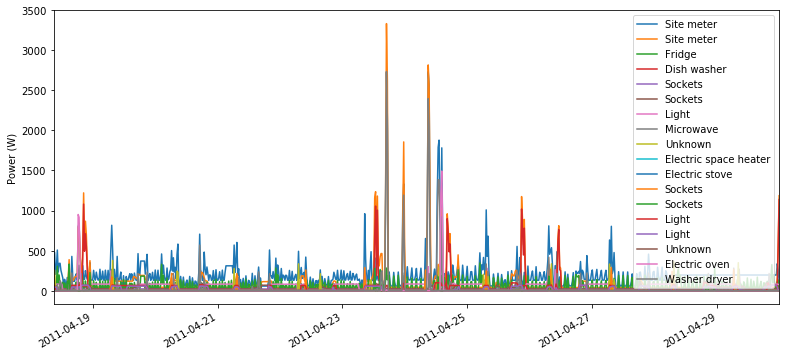

In [4]:
train_elec.plot()

In [5]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [6]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Done training!
Runtime = 1.85953688621521 seconds.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge',

In [7]:
appliance_labels = [m.label() for m in gt.columns.values]
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

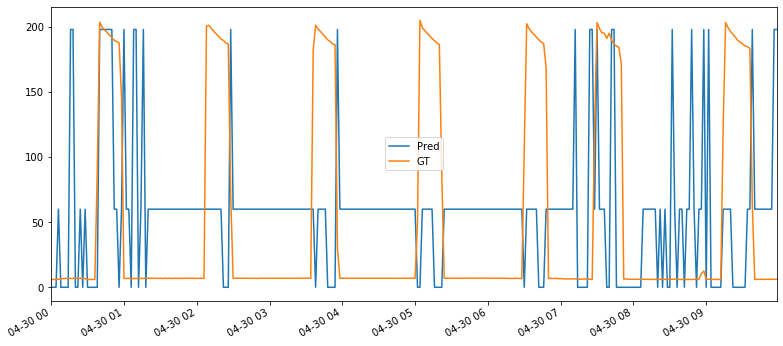

In [33]:
predictions['CO']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

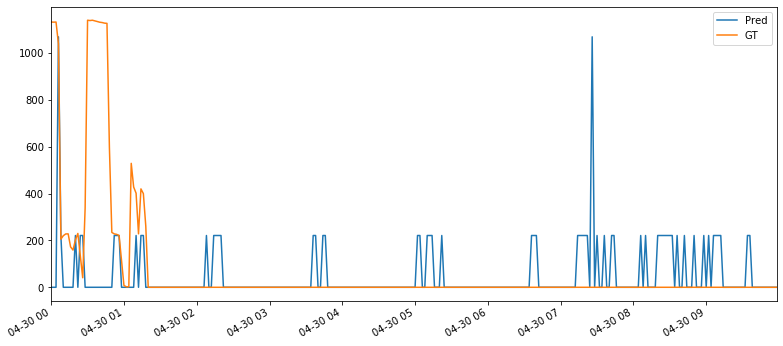

In [24]:
predictions['CO']['Dish washer'].head(300).plot(label="Pred")
gt['Dish washer'].head(300).plot(label="GT")
plt.legend()

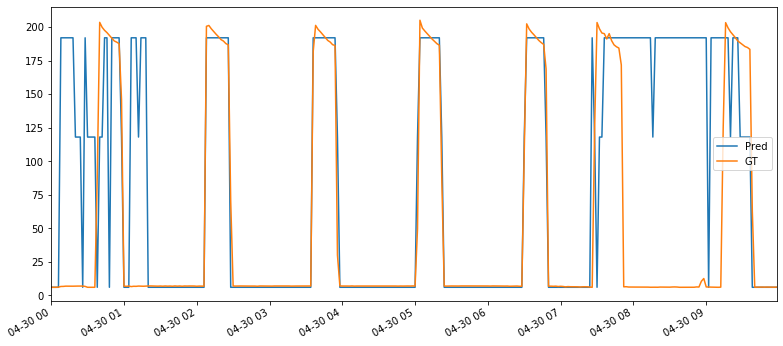

In [9]:
predictions['FHMM']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

In [38]:
import metrics
for clf_name in classifiers.keys():
    print("============ Mean absolute error(in Watts): {}".format(nilmtk.utils.compute_rmse(gt, predictions[clf_name])))

============ Mean absolute error(in Watts): Fridge         107.496056
Light          125.125023
Sockets         24.374077
Microwave      527.749023
Dish washer    233.762344
dtype: float64
============ Mean absolute error(in Watts): Fridge         100.298563
Light           73.632429
Sockets         37.154094
Microwave      545.865461
Dish washer    186.108221
dtype: float64


In [11]:
from rnndisaggregator import RNNDisaggregator
rnn = RNNDisaggregator()
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['microwave'] # The microwave meter that is used as a training target

rnn.train(train_mains, train_meter, epochs=5, sample_period=1)


Using TensorFlow backend.


Epoch 1/5
1003066/1003066 [==============================] - 292s 291us/step - loss: 0.0011
Epoch 2/5
1003066/1003066 [==============================] - 294s 293us/step - loss: 7.3333e-04
Epoch 3/5
1003066/1003066 [==============================] - 296s 295us/step - loss: 6.6731e-04
Epoch 4/5
1003066/1003066 [==============================] - 296s 295us/step - loss: 6.6042e-04
Epoch 5/5
1003066/1003066 [==============================] - 296s 295us/step - loss: 6.5754e-04


In [12]:
test_mains = test_elec.mains().all_meters()[0]
disag_filename = 'disag-out.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

In [13]:
# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
rnn.disaggregate(test_mains, output, train_meter, sample_period=1)


result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['microwave']
ground_truth = test_elec['microwave']

import matplotlib.pyplot as plt
predicted.plot(label="Pred")
ground_truth.plot(label="GT")
plt.show()

New sensible chunk: 121482
New sensible chunk: 112661
New sensible chunk: 87770
New sensible chunk: 54084
New sensible chunk: 2660
New sensible chunk: 33513
New sensible chunk: 138535
New sensible chunk: 32514
New sensible chunk: 27255
New sensible chunk: 34833
New sensible chunk: 100831


TypeError: load() got an unexpected keyword argument 'label'

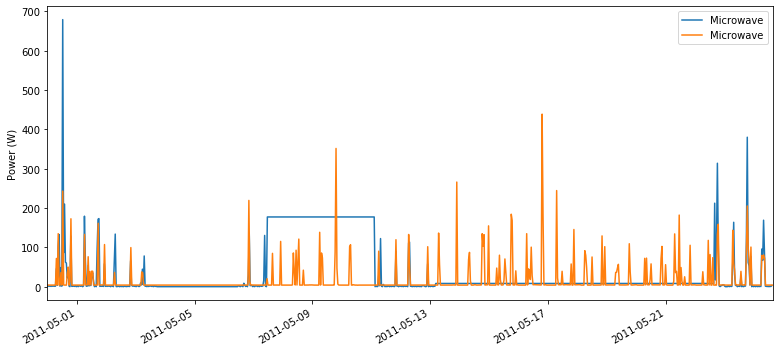

In [15]:
predicted.plot()
ground_truth.plot()
plt.show()

In [16]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

============ Recall: 0.04832915743033944
============ Precision: 0.7995997969118657
============ Accuracy: 0.28442706881393004
============ F1 Score: 0.0911491092934778
============ Relative error in total energy: 0.8032911545221258
============ Mean absolute error(in Watts): 22.006922705899278


Epoch 1/5
100307/100307 [==============================] - 37s 367us/step - loss: 0.0011
Epoch 2/5
100307/100307 [==============================] - 35s 348us/step - loss: 0.0010
Epoch 3/5
100307/100307 [==============================] - 34s 342us/step - loss: 0.0010
Epoch 4/5
100307/100307 [==============================] - 31s 313us/step - loss: 0.0010
Epoch 5/5
100307/100307 [==============================] - 32s 324us/step - loss: 0.0010
New sensible chunk: 121482
New sensible chunk: 112661
New sensible chunk: 87770
New sensible chunk: 54084
New sensible chunk: 2660
New sensible chunk: 33513
New sensible chunk: 138535
New sensible chunk: 32514
New sensible chunk: 27255
New sensible chunk: 34833
New sensible chunk: 100831


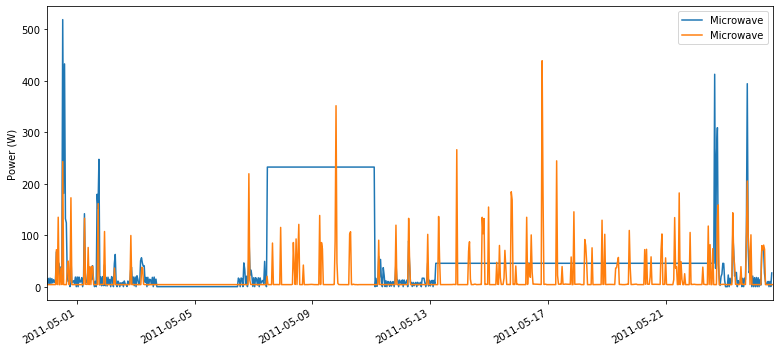

============ Recall: 0.31019437805520855
============ Precision: 0.746872799659246
============ Accuracy: 0.4097902772714601
============ F1 Score: 0.4383368407627064
============ Relative error in total energy: 0.8441557855477156
============ Mean absolute error(in Watts): 29.879237347510433


In [42]:
rnn = RNNDisaggregator()
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['microwave'] # The microwave meter that is used as a training target

rnn.train(train_mains, train_meter, epochs=5, sample_period=10)

test_mains = test_elec.mains().all_meters()[0]
disag_filename = 'disag-out8.h5' # The filename of the resulting datastore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
rnn.disaggregate(test_mains, output, train_meter, sample_period=1)


result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['microwave']
ground_truth = test_elec['microwave']

predicted.plot()
ground_truth.plot()
plt.show()

rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

Epoch 1/5
1003066/1003066 [==============================] - 338s 337us/step - loss: 2.6604e-04
Epoch 2/5
1003066/1003066 [==============================] - 343s 342us/step - loss: 2.4841e-04
Epoch 3/5
1003066/1003066 [==============================] - 331s 330us/step - loss: 2.3272e-04
Epoch 4/5
1003066/1003066 [==============================] - 315s 314us/step - loss: 1.5900e-04
Epoch 5/5
1003066/1003066 [==============================] - 327s 326us/step - loss: 1.5667e-04
New sensible chunk: 121482
New sensible chunk: 112661
New sensible chunk: 87770
New sensible chunk: 54084
New sensible chunk: 2660
New sensible chunk: 33513
New sensible chunk: 138535
New sensible chunk: 32514
New sensible chunk: 27255
New sensible chunk: 34833
New sensible chunk: 100831


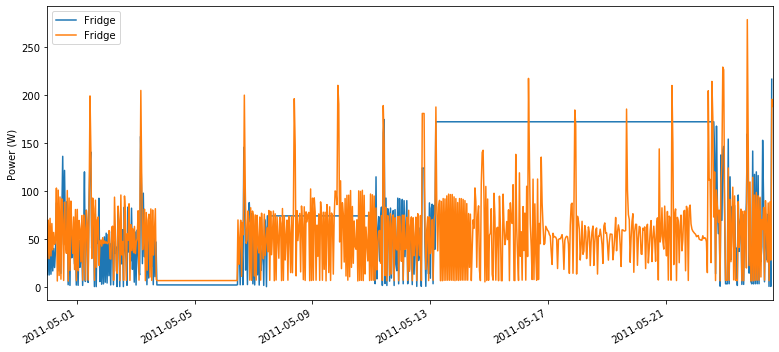

============ Recall: 0.36195415110104134
============ Precision: 0.9555013768789574
============ Accuracy: 0.471585304398173
============ F1 Score: 0.5250237027345788
============ Relative error in total energy: 0.7023136181085731
============ Mean absolute error(in Watts): 42.134383756891566


In [17]:
rnn = RNNDisaggregator()
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['fridge'] # The microwave meter that is used as a training target

rnn.train(train_mains, train_meter, epochs=5, sample_period=1)

test_mains = test_elec.mains().all_meters()[0]
disag_filename = 'disag-out1.h5' # The filename of the resulting datastore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
rnn.disaggregate(test_mains, output, train_meter, sample_period=1)


result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

predicted.plot()
ground_truth.plot()
plt.show()

rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

Epoch 1/5
100307/100307 [==============================] - 37s 368us/step - loss: 3.4505e-04
Epoch 2/5
100307/100307 [==============================] - 34s 340us/step - loss: 2.5589e-04
Epoch 3/5
100307/100307 [==============================] - 34s 340us/step - loss: 2.4474e-04
Epoch 4/5
100307/100307 [==============================] - 32s 324us/step - loss: 2.4398e-04
Epoch 5/5
100307/100307 [==============================] - 35s 349us/step - loss: 2.4292e-04
New sensible chunk: 12149
New sensible chunk: 11267
New sensible chunk: 8778
New sensible chunk: 5409
New sensible chunk: 267
New sensible chunk: 3352
New sensible chunk: 13854
New sensible chunk: 3252
New sensible chunk: 2727
New sensible chunk: 3484
New sensible chunk: 10084


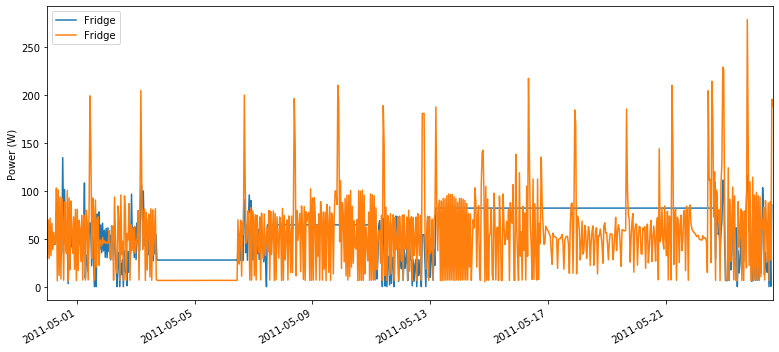

============ Recall: 0.9979810529585339
============ Precision: 0.39886617561863774
============ Accuracy: 0.6100813531154089
============ F1 Score: 0.5699419060148708
============ Relative error in total energy: 0.2429415026817073
============ Mean absolute error(in Watts): 38.70247459266869


In [40]:
rnn = RNNDisaggregator()
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['fridge'] # The microwave meter that is used as a training target

rnn.train(train_mains, train_meter, epochs=5, sample_period=10)

test_mains = test_elec.mains().all_meters()[0]
disag_filename = 'disag-out6.h5' # The filename of the resulting datastore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
rnn.disaggregate(test_mains, output, train_meter, sample_period=10)


result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

predicted.plot()
ground_truth.plot()
plt.show()

rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

In [18]:
from shortseq2pointdisaggregator import ShortSeq2PointDisaggregator
disaggregator = ShortSeq2PointDisaggregator(window_size=100)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 100, 30)           330       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 30)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 30)           7230      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 30)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 40)           7240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 40)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 100, 50)          

In [20]:
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['microwave'] # The microwave meter that is used as a training target

disaggregator.train(train_mains, train_meter, epochs=5, sample_period=10)

Epoch 1/5
100208/100208 [==============================] - 154s 2ms/step - loss: 0.0011
Epoch 2/5
100208/100208 [==============================] - 151s 2ms/step - loss: 9.2236e-04
Epoch 3/5
100208/100208 [==============================] - 153s 2ms/step - loss: 8.4729e-04
Epoch 4/5
100208/100208 [==============================] - 162s 2ms/step - loss: 8.0944e-04
Epoch 5/5
100208/100208 [==============================] - 159s 2ms/step - loss: 7.7270e-04


In [30]:
disag_filename = 'disag-out2.h5' # The filename of the resulting datastore
output = HDFDataStore(disag_filename, 'w')

New sensible chunk: 12149
New sensible chunk: 11267
New sensible chunk: 8778
New sensible chunk: 5409
New sensible chunk: 267
New sensible chunk: 3352
New sensible chunk: 13854
New sensible chunk: 3252
New sensible chunk: 2727
New sensible chunk: 3484
New sensible chunk: 10084


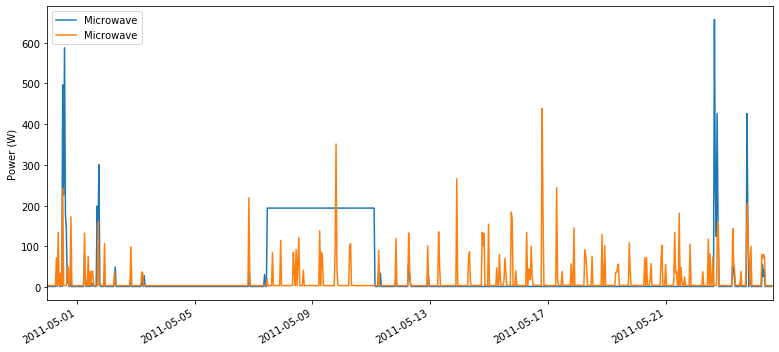

============ Recall: 0.6912759115656681
============ Precision: 0.998174065611229
============ Accuracy: 0.6996351554739085
============ F1 Score: 0.8168500949162606
============ Relative error in total energy: 0.922875880164121
============ Mean absolute error(in Watts): 7.186779036379039


In [35]:
# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
disaggregator.disaggregate(test_mains, output, train_meter, sample_period=10)

result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['microwave']
ground_truth = test_elec['microwave']

predicted.plot()
ground_truth.plot()
plt.show()

rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 100, 30)           330       
_________________________________________________________________
dropout_79 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 100, 30)           7230      
_________________________________________________________________
dropout_80 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 100, 40)           7240      
_________________________________________________________________
dropout_81 (Dropout)         (None, 100, 40)           0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 100, 50)         

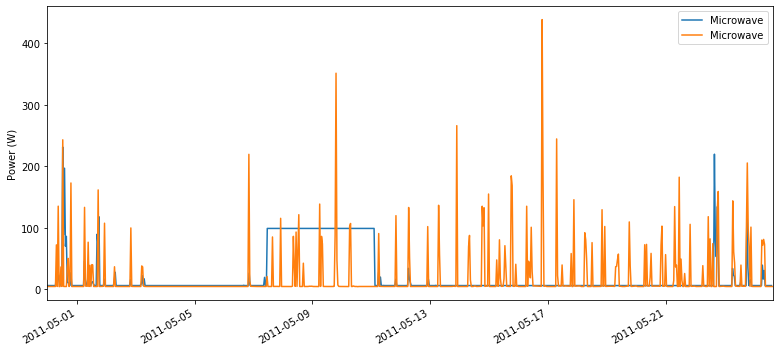

============ Recall: 0.8495297805642633
============ Precision: 0.25100339610991046
============ Accuracy: 0.9650454273434524
============ F1 Score: 0.3875119161105815
============ Relative error in total energy: 0.25056500726045566
============ Mean absolute error(in Watts): 18.058783935807252


In [51]:
disaggregator = ShortSeq2PointDisaggregator(window_size=100)
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['microwave'] # The microwave meter that is used as a training target

disaggregator.train(train_mains, train_meter, epochs=4, sample_period=50)
disag_filename = 'disag-out15.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
disaggregator.disaggregate(test_mains, output, train_meter, sample_period=10)

result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['microwave']
ground_truth = test_elec['microwave']

predicted.plot()
ground_truth.plot()
plt.show()

rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 100, 30)           330       
_________________________________________________________________
dropout_67 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 100, 30)           7230      
_________________________________________________________________
dropout_68 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 100, 40)           7240      
_________________________________________________________________
dropout_69 (Dropout)         (None, 100, 40)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 100, 50)         

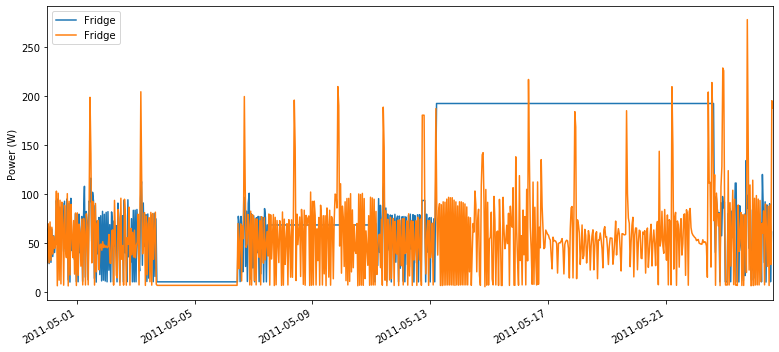

============ Recall: 0.9994743481917577
============ Precision: 0.27418238449558746
============ Accuracy: 0.3152712039606115
============ F1 Score: 0.43031729507083694
============ Relative error in total energy: 0.008583942364665207
============ Mean absolute error(in Watts): 17.84168453878005


In [49]:
disaggregator = ShortSeq2PointDisaggregator(window_size=100)
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['fridge'] # The microwave meter that is used as a training target

disaggregator.train(train_mains, train_meter, epochs=5, sample_period=10)
disag_filename = 'disag-out13.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
disaggregator.disaggregate(test_mains, output, train_meter, sample_period=10)

result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

predicted.plot()
ground_truth.plot()
plt.show()

rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 100, 30)           330       
_________________________________________________________________
dropout_61 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 100, 30)           7230      
_________________________________________________________________
dropout_62 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 100, 40)           7240      
_________________________________________________________________
dropout_63 (Dropout)         (None, 100, 40)           0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 100, 50)         

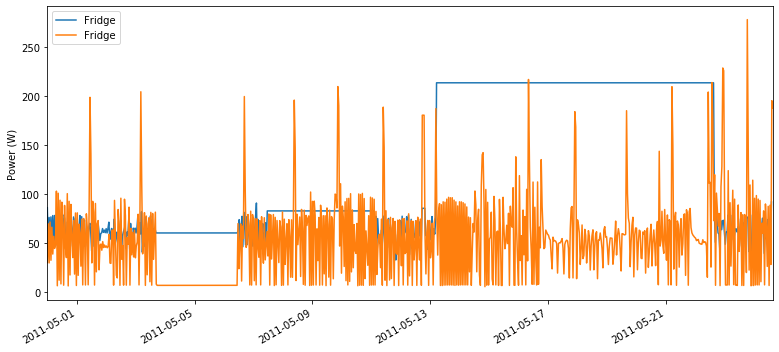

============ Recall: 0.9976871320437343
============ Precision: 0.27896995708154504
============ Accuracy: 0.33219084924650455
============ F1 Score: 0.43602113484952904
============ Relative error in total energy: 0.08052864822979107
============ Mean absolute error(in Watts): 60.59150695331882


In [48]:
disaggregator = ShortSeq2PointDisaggregator(window_size=100)
train_mains = train_elec.mains().all_meters()[0] # The aggregated meter that provides the input
train_meter = train_elec.submeters()['fridge'] # The microwave meter that is used as a training target

disaggregator.train(train_mains, train_meter, epochs=4, sample_period=50)
disag_filename = 'disag-out12.h5' # The filename of the resulting datastore
from nilmtk.datastore import HDFDataStore
output = HDFDataStore(disag_filename, 'w')

# test_mains: The aggregated signal meter
# output: The output datastore
# train_meter: This is used in order to copy the metadata of the train meter into the datastore
disaggregator.disaggregate(test_mains, output, train_meter, sample_period=10)

result = DataSet(disag_filename)
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

predicted.plot()
ground_truth.plot()
plt.show()

rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))